In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile
import random

from collections import defaultdict
from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat

from tensorflow.keras import Model, Input, Sequential, initializers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Layer, InputSpec, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, Flatten, Activation
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.set_floatx('float64')
dir_name = "aclImdb/"
special_tokens = ["<UNK>", "<PAD>"]

# Download data

In [2]:
def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

download_file("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", "imdb")

In [3]:
len(os.listdir("aclImdb/train/pos"))

12500

# Read data

In [2]:
idx2word = special_tokens
word2idx = defaultdict(lambda: 1)
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
with open(dir_name + "imdb.vocab", encoding="utf-8") as f:
    for word in f:
        word = word.strip()
        idx2word.append(word)
        word2idx[word] = len(idx2word) - 2
        
print("Vocab length: %d" % len(idx2word))

def read_review_data(folder):
    raw_review_data = []
    for filename in os.listdir(dir_name + folder + "/neg"):
        with open(dir_name + folder + "/neg/" + filename, encoding="utf-8") as f:
            raw_review_data.append((f.read(), 0))

    for filename in os.listdir(dir_name + folder + "/pos"):
        with open(dir_name + folder + "/pos/" + filename, encoding="utf-8") as f:
            raw_review_data.append((f.read(), 1))
    
    random.shuffle(raw_review_data)
    return raw_review_data

raw_train_data = read_review_data("train")
raw_test_data = read_review_data("test")
        
train_len = len(raw_train_data)
val_len = int(train_len * 0.1)
raw_val_data = raw_train_data[:val_len]
raw_train_data = raw_train_data[val_len:]

print("Train size: %d. Val size: %d. Test size: %d." % (len(raw_train_data), len(raw_val_data), len(raw_test_data)))

Vocab length: 89529
Train size: 22500. Val size: 2500. Test size: 25000.


# Convert texts into arrays of indexes

## 1. Tokenize

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
from bpemb import BPEmb

bpemb_en = BPEmb(lang="en", vs=200000)

def tokenize_bpe(text):
    return [t.replace("▁", "") for t in bpemb_en.encode(text)]

def tokenize(text):
    return [t.lower() for t in word_tokenize(text)]

print(tokenize_bpe("London is the capital of great Britain!"))

c:\users\r.cherny\appdata\local\programs\python\python37\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


['london', 'is', 'the', 'capital', 'of', 'great', 'britain', '!']


## 2. Preprocess

In [4]:
import re
cleanr = re.compile('<.*?>')

def preprocess(text):
    cleantext = re.sub(cleanr, '', text)
    return cleantext

print(preprocess("<b>bold text</b>"))

bold text


##  3. Remove stop words

In [5]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return [t for t in tokens if any(c.isalpha() for c in t) and t not in english_stopwords]

print(remove_stop_words(tokenize_bpe("London is the capital of great Britain!")))

['london', 'capital', 'great', 'britain']


## 4. Putting all together

In [6]:
def text2tokens(text):
    text = preprocess(text)
    tokens = tokenize_bpe(text)
    tokens = remove_stop_words(tokens)
    return tokens

train_data = [(text2tokens(t), label) for t, label in raw_train_data]
val_data = [(text2tokens(t), label) for t, label in raw_val_data]
test_data = [(text2tokens(t), label) for t, label in raw_test_data]

In [10]:
print(text2tokens("London is the capital of great Britain!"))
print(train_data[0][0])

['london', 'capital', 'great', 'britain']
['enjoyed', 'story', 'things', 'learned', 'wwi', 'planes', 'boats', 'make', 'movie', 'must', 'see', 'close', 'ups', 'plane', 'torpedo', 'boat', 'used', 'completely', 'new', 'heartily', 'recommend']


# Analyze data

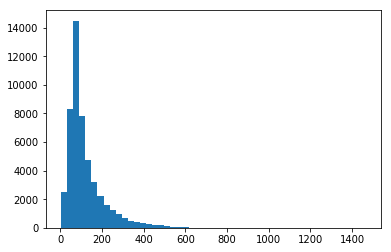

In [8]:
import matplotlib.pyplot as plt

lengths = [len(t[0]) for t in test_data] + [len(t[0]) for t in val_data] + [len(t[0]) for t in train_data]
plt.hist(lengths, bins = 50)
plt.show()

# Pad data

In [7]:
def pad_data(tokens, max_length):
    idxs = [word2idx[word] for word in tokens]
    pad_idx = word2idx["<PAD>"]
    if len(idxs) < max_length:
        idxs.extend([pad_idx] * (max_length - len(idxs)))
    else:
        return np.array(idxs[:max_length])
    return np.array(idxs)

def unzip(data):
    return np.array([t[0] for t in data]), np.array([t[1] for t in data])

In [8]:
max_length = 600

x_train, y_train = unzip([(pad_data(t, max_length), label) for t, label in train_data])
x_val, y_val = unzip([(pad_data(t, max_length), label) for t, label in val_data])
x_test, y_test = unzip([(pad_data(t, max_length), label) for t, label in test_data])

print(np.array(x_train[0]))

[ 2805 11246   990   286   107   203  8237   172   659   185   280  2207
  5643 11043 14778  6966 11135   891   164  3212   291  1704  4960  1182
   847   445  1730  2462  1730    62  1068  6127  1024    84   401  1855
  2812  1841  1423   106  1720   378   327    95    16  2512  8608  2836
   229  1537 12323  7075  1356 16608    80   180  1920  4983   245  1956
 87739  3684   160   984    27 77503     1  2754   146   117   820  4983
   103  8120  2812  3197 13390   565  3429   142  1914    72   223   882
  1674 26970   312  1182   312   459   571   189    58   104   344   990
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [13]:
n_words = len(idx2word)
embedding_dim = 50
batch_size = 32

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 50)           4476450   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,535,459
Trainable params: 4,535,459
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=2, verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 772s 34ms/sample - loss: 0.5011 - accuracy: 0.7622 - val_loss: 0.3698 - val_accuracy: 0.8656
Epoch 2/2
22500/22500 [==============================] - 800s 36ms/sample - loss: 0.3014 - accuracy: 0.8802 - val_loss: 0.3010 - val_accuracy: 0.8792


25000/25000 [==============================] - 80s 3ms/sample - loss: 0.3539 - accuracy: 0.8473


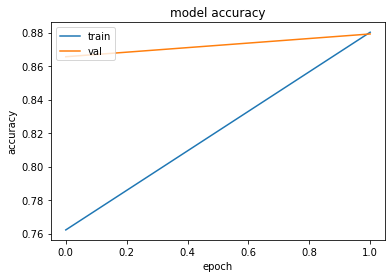

In [15]:
model.evaluate(x_test, y_test)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()

# GloVe embeddings

## 1. Download embeddings

In [11]:
import urllib.request
import zipfile

url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
urllib.request.urlretrieve(url, 'twitter_glove')
with zipfile.ZipFile('twitter_glove', 'r') as zip_ref:
    zip_ref.extractall('twitter_glove_data')

## 2. Load embeddings

In [8]:
embedding_dim = 50

def load_glove_embeddings(embedding_dim, special_tokens):
    word2idx = defaultdict(lambda: 0)
    idx2word = special_tokens
    glove_weights = []
    for i, word in enumerate(idx2word):
        word2idx[word] = i
        glove_weights.append(np.zeros(embedding_dim))

    with open("twitter_glove_data/glove.twitter.27B.%dd.txt" % embedding_dim, "r", encoding="utf-8") as f:
        for line in f:
            word, *vector = line.split(' ')
            vector = np.array([float(v) for v in vector])
            word2idx[word] = len(idx2word)
            idx2word.append(word)
            glove_weights.append(vector)
    glove_weights = np.array(glove_weights)
    return word2idx, idx2word, glove_weights

word2idx, idx2word, glove_weights = load_glove_embeddings(embedding_dim, special_tokens)

In [9]:
max_length = 600

x_train, y_train = unzip([(pad_data(t, max_length), label) for t, label in train_data])
x_val, y_val = unzip([(pad_data(t, max_length), label) for t, label in val_data])
x_test, y_test = unzip([(pad_data(t, max_length), label) for t, label in test_data])

In [10]:
n_words = len(idx2word)
batch_size = 128
max_len = 600

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, 
              weights=[glove_weights], 
              trainable=False, 
              input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 50)           64152150  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 64,211,159
Trainable params: 59,009
Non-trainable params: 64,152,150
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 1193s 53ms/sample - loss: 0.5577 - accuracy: 0.7154 - val_loss: 0.4807 - val_accuracy: 0.7776
Epoch 2/5
22500/22500 [==============================] - 1292s 57ms/sample - loss: 0.4795 - accuracy: 0.7770 - val_loss: 0.4728 - val_accuracy: 0.7696
Epoch 3/5
22500/22500 [==============================] - 1337s 59ms/sample - loss: 0.4491 - accuracy: 0.7947 - val_loss: 0.4600 - val_accuracy: 0.7748
Epoch 4/5
22500/22500 [==============================] - 1372s 61ms/sample - loss: 0.4320 - accuracy: 0.8048 - val_loss: 0.4164 - val_accuracy: 0.8184
Epoch 5/5
22500/22500 [==============================] - 1416s 63ms/sample - loss: 0.4467 - accuracy: 0.7984 - val_loss: 0.4055 - val_accuracy: 0.8212


25000/25000 [==============================] - 86s 3ms/sample - loss: 0.4114 - accuracy: 0.8162


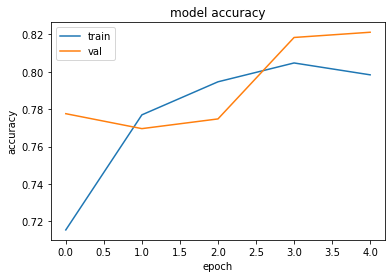

In [12]:
model.evaluate(x_test, y_test)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Enhance model

In [13]:
n_words = len(idx2word)
batch_size = 128
max_len = 600
embedding_dim = 50

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, 
              weights=[glove_weights], 
              trainable=False, 
              input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])


model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 50)           64152150  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 64,244,183
Trainable params: 92,033
Non-trainable params: 64,152,150
_____________________________________

In [14]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 1542s 69ms/sample - loss: 0.5645 - accuracy: 0.7159 - val_loss: 0.5000 - val_accuracy: 0.7676
Epoch 2/5
22500/22500 [==============================] - 1712s 76ms/sample - loss: 0.4832 - accuracy: 0.7766 - val_loss: 0.4700 - val_accuracy: 0.7752
Epoch 3/5
22500/22500 [==============================] - 1841s 82ms/sample - loss: 0.4598 - accuracy: 0.7927 - val_loss: 0.4536 - val_accuracy: 0.7844
Epoch 4/5
22500/22500 [==============================] - 1978s 88ms/sample - loss: 0.4268 - accuracy: 0.8101 - val_loss: 0.3993 - val_accuracy: 0.8272
Epoch 5/5
22500/22500 [==============================] - 2145s 95ms/sample - loss: 0.3956 - accuracy: 0.8281 - val_loss: 0.3869 - val_accuracy: 0.8320


25000/25000 [==============================] - 129s 5ms/sample - loss: 0.3928 - accuracy: 0.8292


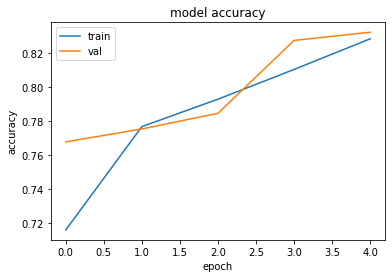

In [15]:
model.evaluate(x_test, y_test)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Existing model

In [ ]:
import zipfile

urlretrieve("https://github.com/bfelbo/DeepMoji/archive/master.zip", "master.zip")
with zipfile.ZipFile("master.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


urlretrieve("https://uc5e9e71e056a7db22fe03924e9c.dl.dropboxusercontent.com/cd/0/get/A1kiXKCzvHsOx7AasrgtoVozK8wpXlIbyQkFCplavFNREAZ-kYxGkiVctR02z9uld00rTMQFwL4nl26dUdlYGtzOOh42VDS_V0uEMDae9cvKkw/file?_download_id=65003392492753452134180909853568979055614964122693868972846519&_notify_domain=www.dropbox.com&dl=1", "deepmoji_weights.hdf5")

In [22]:
import sys
sys.path.insert(0, "C:\\Users\\r.cherny\\Lab 7\\DeepMoji-master")
sys.path.insert(0, "C:\\Users\\r.cherny\\Lab 7\\DeepMoji-master\\deepmoji")

In [27]:
import json

VOCAB_PATH = "DeepMoji-master/model/vocabulary.json"
print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    word2idx = json.load(f)
    
idx2word = [None] * len(word2idx)
for word, idx in word2idx.items():
    idx2word[idx] = word

Tokenizing using dictionary from DeepMoji-master/model/vocabulary.json


In [28]:
def text2idxs_deep_emoji(text, max_len=600):
    text = preprocess(text)
    tokens = tokenize(text)
    tokens = [t for t in tokens if t not in english_stopwords]
    idxs = []
    for token in tokens:
        if token not in word2idx:
            idxs.append(word2idx["CUSTOM_UNKNOWN"])
        else:
            idxs.append(word2idx[token])
    pad_idx = word2idx["CUSTOM_MASK"]
    if len(idxs) < max_len:
        idxs.extend([pad_idx] * (max_len - len(idxs)))
    else:
        return np.array(idxs[:max_length])
    return np.array(idxs)

emoji_train_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_train_data]
emoji_val_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_val_data]
emoji_test_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_test_data]

In [30]:
x_emoji_train, y_emoji_train = unzip(emoji_train_data)
x_emoji_val, y_emoji_val = unzip(emoji_val_data)
x_emoji_test, y_emoji_test = unzip(emoji_test_data)

In [46]:
from deepmoji.model_def import deepmoji_transfer
from deepmoji.finetuning import finetune

nb_classes = 2
max_len = 600

deepmoji_base = deepmoji_transfer(nb_classes, max_len, "deepmoji_weights.hdf5")
deepmoji_base.layers.pop()
for layer in deepmoji_base.layers:
    layer.trainable = False

x = deepmoji_base.layers[-1].output
x = keras.layers.Dense(128, activation='relu')(x)
preds = keras.layers.Dense(1, activation='sigmoid')(x)

deepmoji_model = keras.Model(deepmoji_base.input, outputs=preds)
deepmoji_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
deepmoji_model.summary()

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 256)     12800000    input_6[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 600, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 600,

In [47]:
history = deepmoji_model.fit(x_emoji_train, y_emoji_train, validation_data=(x_emoji_val, y_emoji_val), batch_size=batch_size, epochs=2, verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 3257s 145ms/step - loss: 0.4915 - accuracy: 0.7811 - val_loss: 0.3985 - val_accuracy: 0.8252
Epoch 2/2
22500/22500 [==============================] - 2902s 129ms/step - loss: 0.4507 - accuracy: 0.8008 - val_loss: 0.3863 - val_accuracy: 0.8340


In [52]:
predictions = deepmoji_model.predict(x_emoji_test)

In [73]:
import math
accurate_total = 0
total = len(x_emoji_test)
for i in range(total):
    expected = y_emoji_test[i]
    actual = predictions[i]
    if actual > 0.51:
        actual = 1
    else:
        actual = 0
    if actual == expected:
        accurate_total += 1
print(accurate_total / total)


0.83468


25000/25000 [==============================] - 8041s 322ms/step


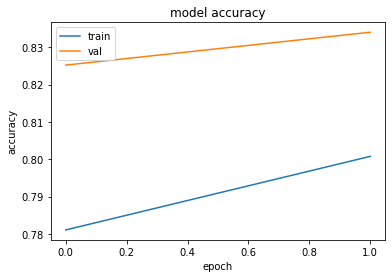

In [50]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(temp_history.history['accuracy'])
plt.plot(temp_history.history['val_accuracy'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()